# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("..")

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pickle
import numpy as np
import pandas as pd
from src.utils import train_and_eval,run_single_experiment
import datetime as dt
import os
from IPython.display import display, Markdown
from matplotlib import pyplot as plt
import random

In [4]:
seed=1000
np.random.seed(seed)
torch.manual_seed(seed)
random.seed(seed)

# Prepare folders

In [5]:
if not os.path.exists('../outputs/'):
    os.makedirs('../outputs/')
    
if not os.path.exists('../outputs/lag'):
    os.makedirs('../outputs/lag')
    
if not os.path.exists('../outputs/temperature'):
    os.makedirs('../outputs/temperature')
    
if not os.path.exists('../outputs/final_result'):
    os.makedirs('../outputs/final_result')

In [6]:
ts_file_path='../data/dataset7.pickle'

# Find optimal window

In [7]:
repeats=5
epochs=20
window_length=10 # Maximal window length
mask_list=[x for x in range(1,window_length)]

In [8]:
results = []

# Iterate over each mask lag value
for mask_lag in mask_list:
    print(f"Current mask: {mask_lag}")
    # Run the single experiment for the current mask_lag
    result = run_single_experiment(ts_file_path, '../outputs/lag', window_length,mask_lag, repeats, temperature=1,epochs=epochs)
    results.append(result)

# Convert the result list to a DataFrame
results_df = pd.DataFrame(results)

Current mask: 1
Current mask: 2
Current mask: 3
Current mask: 4
Current mask: 5
Current mask: 6
Current mask: 7
Current mask: 8
Current mask: 9


In [9]:
# Optimal timewindow is the one with lowest loss on test set
opt_window_length=window_length-results_df.sort_values(['test_loss_mean'])['mask_lag'].values[0]
print(opt_window_length)

5


In [10]:
# Deinfe array of temperatures to check
temp_array=[1e-5,1e-4,1e-3,1e-2,1e-1,1,1e1,1e2,1e3,1e4,1e5]

In [11]:
results = []

# Iterate over each temperature value
for temperature in temp_array:
    print(f"Current temperature: {temperature}")
    # Run the single experiment for the currenttemperature
    result = run_single_experiment(ts_file_path, '../outputs/temperature', opt_window_length, 0, repeats, temperature,epochs=epochs)
    results.append(result)

# Convert the result list to a DataFrame
results_df = pd.DataFrame(results)

Current temperature: 1e-05
Current temperature: 0.0001
Current temperature: 0.001
Current temperature: 0.01
Current temperature: 0.1
Current temperature: 1
Current temperature: 10.0
Current temperature: 100.0
Current temperature: 1000.0
Current temperature: 10000.0
Current temperature: 100000.0


In [12]:
filtered_names=set(sorted([str(x.split('_')[5]) for x in os.listdir('../outputs/temperature/') ]))

In [13]:
opt_temperature_metric=[]
temp_array=[]
for name in filtered_names:
    name=str(name)
    # display(Markdown(f'# {name}'))
    exp_coeffs=[x for x in sorted(os.listdir('../outputs/temperature/')) if name in x]
    beta_list=[]
    for coef_path in exp_coeffs:
        # print(coef_path)
        f,c=pickle.load(open(f'../outputs/temperature/{coef_path}','rb'))
        beta_tilda=(f*c).abs().mean(0).sum(2)
        beta=beta_tilda/beta_tilda.sum(1,keepdims=True)
        beta_list.append(beta.detach().cpu().numpy().max(1).sum())

    temp_array.append(float(name[11:]))
    beta_list=np.array(beta_list)
    opt_temperature_metric.append(beta_list.mean(0))

In [14]:
temp_df=pd.DataFrame({'temperature':temp_array,'metric':opt_temperature_metric})
temp_df.sort_values(by=['temperature'])

,temperature,metric
4,0.00001,2.208345
3,0.00010,2.364522
7,0.00100,2.214108
5,0.01000,2.213637
2,0.10000,2.708968
8,1.00000,2.074090
0,10.00000,2.056819
6,100.00000,1.951095
1,1000.00000,2.054626
10,10000.00000,2.023815


In [15]:
opt_temperature=temp_df.sort_values(by=['metric'],ascending=False)['temperature'].values[0]
opt_temperature

0.1

In [16]:
result = run_single_experiment(ts_file_path, '../outputs/final_result', opt_window_length, 0, repeats,opt_temperature ,epochs=epochs,save_coeffs_on_test_set=True,save_coefficients=False)

dcits_testset_20240819_170704_run1_mask0_temperature0.1_a_c.p
dcits_testset_20240819_170754_run3_mask0_temperature0.1_a_c.p
dcits_testset_20240819_170729_run2_mask0_temperature0.1_a_c.p
dcits_testset_20240819_170639_run0_mask0_temperature0.1_a_c.p
dcits_testset_20240819_170819_run4_mask0_temperature0.1_a_c.p


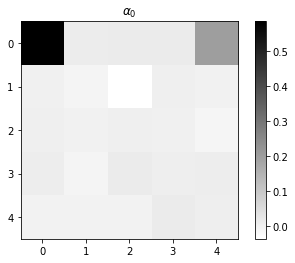

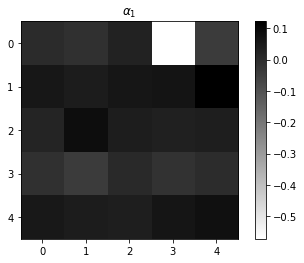

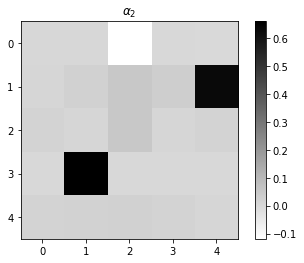

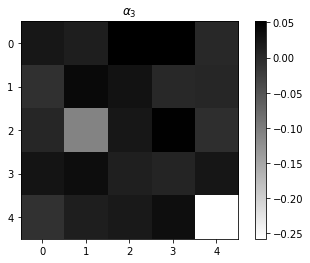

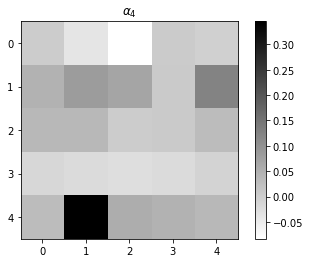

In [23]:
alpha_list=[]
beta_list=[]
for coef_path in os.listdir('../outputs/final_result/'):
    print(coef_path)
    f,c=pickle.load(open(f'../outputs/final_result/{coef_path}','rb'))
    alpha_run=(f*c).mean(dim=(0))
    beta_run=((f*c).abs().mean(0).sum(2)/(f*c).abs().mean(0).sum(2).sum(1,keepdims=True))
    alpha_list.append(alpha_run)
    beta_list.append(beta_run)

alpha_list=torch.stack(alpha_list)
alpha=alpha_list.mean(0).detach().cpu().numpy()
beta_list=torch.stack(beta_list)
beta=beta_list.mean(0).detach().cpu().numpy()

for i in range(0,alpha.shape[0]):
    plt.imshow(alpha[i],cmap=plt.cm.binary)
    plt.colorbar()
    plt.title(fr'$\alpha_{i}$')
    plt.show()

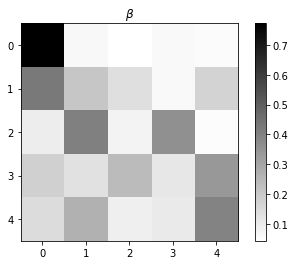

In [21]:
plt.imshow(beta,cmap=plt.cm.binary)
plt.title(fr'$\beta$')
plt.colorbar()
plt.show()

In [20]:
beta

array([[0.7719542 , 0.06616247, 0.04388179, 0.06224767, 0.05575393],
       [0.4227334 , 0.2081565 , 0.13577148, 0.0635529 , 0.16978574],
       [0.09681398, 0.40643826, 0.0807547 , 0.36212698, 0.05386613],
       [0.17855465, 0.1309821 , 0.23802249, 0.113856  , 0.33858475],
       [0.14477633, 0.26660013, 0.08959188, 0.10411346, 0.39491817]],
      dtype=float32)